# Calculate Search Metrics with Dynamic Optimizer

This notebook loads the models that were built in the previous notebook and test how much the queries improve when using a pipeline with the predicted "neuralness" value.

1. Get the models
2. Get the queries
3. Get the ratings file
4. Get the predicted "neuralness" scores for each query from each model
5. Run the queries (two runs per query; one per model)
    1. Create the pipeline with the according "neuralness" and "keywordness" values
    2. Run the query once per model type
    3. Store the results
7. Calculate search metrics
8. Compare search metrics with the best metrics of the notebook that explored all hybrid search configurations 

In [332]:
import pickle
import pandas as pd
import requests
import json
import uuid
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm_notebook

## Load models from the previous notebook

In [333]:
# load the two models
with open('regression_model.pkl', 'rb') as fid:
    regr = pickle.load(fid)

with open('random_forest_model.pkl', 'rb') as fid:
    random_forest = pickle.load(fid)

In [334]:
regr

Ridge(alpha=10.0)

In [335]:
random_forest

RandomForestRegressor(max_depth=3, max_features='log2', min_samples_leaf=4,
                      n_estimators=50, random_state=42)

In [336]:
df_test_data = pd.read_csv('../data/dynamic_optimizer_test_data.csv')

In [337]:
df_test_data.head(5)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
0,1 1/4 pop up bathroom sink drain without overflow,0.044023,0.6,9,49,1,1,91,0.329475,2.666837,0.746640,0.681141
1,1 ‘ velcro without adhesive for sewing,0.086189,0.6,7,38,1,0,0,0.000000,0.000000,0.643718,0.586100
2,10x6 plastic register cover without vent,0.080321,0.6,6,40,1,0,0,0.000000,0.000000,0.581616,0.571584
3,barn pictures for walls,0.245660,0.6,4,23,0,0,80,1.429011,4.140529,0.648646,0.633677
4,black bear onesie,0.488564,0.6,3,17,0,0,5,0.974655,2.471067,0.613293,0.581674


In [338]:
# Get all ratings
DATA_DIR = '/Users/danielwrigley/work/Testing/git_repos/esci-data/shopping_queries_dataset/'

In [339]:
df_examples = pd.read_parquet(DATA_DIR + '/shopping_queries_dataset_examples.parquet')

In [340]:
# Select judgments
# Map esci_label to score
# create judgments per day in range
# create noise in score

label_num = {"E": 0, "S": 1, "C": 2, "I": 3}
label_score = [3, 2, 1, 0]
#label_score = [1, 0.1, 0.01, 0]

def label_to_score(label):
    return label_score[label_num[label]]

df_ratings = df_examples[df_examples["query"].isin(set(df_test_data["query_string"].values))].copy()
df_ratings["judgment"] = df_ratings.esci_label.apply(lambda x: label_to_score(x))
df_ratings["document"] = df_ratings.product_id
df_ratings = df_ratings[["query", "document", "judgment"]].reset_index(drop=True)
df_ratings.head(3)

,query,document,judgment
0,1 1/4 pop up bathroom sink drain without overflow,B07TP9FB7W,3
1,1 1/4 pop up bathroom sink drain without overflow,B07S5ZVKW5,3
2,1 1/4 pop up bathroom sink drain without overflow,B07RLLCV3P,3


In [341]:
df_test_data.shape[0]

50

## Predict the "neuralness" with both models

In [342]:
regr.feature_names_in_

array(['f_1_num_of_terms', 'f_5_num_results', 'f_7_sum_title_scores',
       'f_9_avg_semantic_score'], dtype=object)

In [343]:
random_forest.feature_names_in_

array(['f_4_has_special_char', 'f_5_num_results'], dtype=object)

In [344]:
#feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
#                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
feature_columns_lr = regr.feature_names_in_
feature_columns_rf = random_forest.feature_names_in_
def get_linear_model_prediction(row):
    df_row = pd.DataFrame([row[feature_columns_lr]], columns=feature_columns_lr)
    return regr.predict(df_row)[0]

def get_random_forest_prediction(row):
    df_row = pd.DataFrame([row[feature_columns_lr]], columns=feature_columns_rf)
    return random_forest.predict(df_row)[0]

In [345]:
# make predictions with the two models ensuring that the minimum is not below 0 and the maximum not above 1

df_test_data['linear_model'] = df_test_data.apply(
    lambda row: min(np.max(get_linear_model_prediction(row), 0), 1), axis=1
)

df_test_data['random_forest'] = df_test_data.apply(
    lambda row: min(np.max(get_random_forest_prediction(row), 0), 1), axis=1
)

In [346]:
df_test_data.head(5)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score,linear_model,random_forest
0,1 1/4 pop up bathroom sink drain without overflow,0.044023,0.6,9,49,1,1,91,0.329475,2.666837,0.746640,0.681141,0.898171,0.644802
1,1 ‘ velcro without adhesive for sewing,0.086189,0.6,7,38,1,0,0,0.000000,0.000000,0.643718,0.586100,0.941134,0.936821
2,10x6 plastic register cover without vent,0.080321,0.6,6,40,1,0,0,0.000000,0.000000,0.581616,0.571584,0.904877,0.936821
3,barn pictures for walls,0.245660,0.6,4,23,0,0,80,1.429011,4.140529,0.648646,0.633677,0.652181,0.644802
4,black bear onesie,0.488564,0.6,3,17,0,0,5,0.974655,2.471067,0.613293,0.581674,0.687811,0.647706


## Run the queries of the test set

* Retrieve the model id
* For each query term of the test set:
  * Create the pipeline with the predicted "neuralness" value and the calculated "keywordness" value (`1-"neuralness"`)
  * Run the query once per model type

In [347]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one

headers = {
    'Content-Type': 'application/json'
}

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
   
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [348]:
models = ['linear_model', 'random_forest']
df_relevance = pd.DataFrame()

# iterate over all query strings, create a pipeline with the predicted "neuralness"
# and send a hybrid search query to OpenSearch with the set pipeline

for query in tqdm_notebook(df_test_data.itertuples()):
    for model in models:
        neuralness = df_test_data.loc[df_test_data['query_string'] == query[1], model].iloc[0]
        neuralness = round(neuralness, 2)
        keywordness = 1 - neuralness   
        # Set pipeline 
        url = "http://localhost:9200/ecommerce/_search"
        payload = {
          "_source": {
            "excludes": [
              "title_embedding"
            ]
          },
          "query": {
            "hybrid": {
              "queries": [
                {
                  "multi_match" : {
                      "type":       "best_fields",
                      "fields":     [
                        "product_id^100",
                        "product_bullet_point^3",
                        "product_color^2",
                        "product_brand^5",
                        "product_description",
                        "product_title^10"
                      ],
                      "operator":   "and",
                      "query":      query[1]
                    }
                },
                {
                  "neural": {
                    "title_embedding": {
                      "query_text": query[1],
                      "k": 100
                    }
                  }
                }
              ]
            }
          },
            "search_pipeline": {
              "request_processors": [
                {
                  "neural_query_enricher" : {
                    "description": "one of many search pipelines for experimentation",
                    "default_model_id": model_id,
                    "neural_field_default_id": {
                       "title_embeddings": model_id
                    }
                  }
                }
              ],
              "phase_results_processors": [
                {
                  "normalization-processor": {
                    "normalization": {
                      "technique": "l2"
                    },
                    "combination": {
                      "technique": "arithmetic_mean",
                      "parameters": {
                        "weights": [
                          keywordness,
                          neuralness
                        ]
                      }
                    }
                  }
                }
              ]    
            },
          "size": 100
        }
    
        response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
        #print(response)
        # store results per model and pipeline
        position = 0
        for hit in response['hits']['hits']:
            # create a new row for the DataFrame and append it
            row = { 'query_id' : str(query[0]), 'query_string': query[1], 'product_id' : hit["_id"], 'position' : str(position), 'relevance' : hit["_score"], 'run': model, 'neuralness': neuralness }
    
            new_row_df = pd.DataFrame([row])
            df_relevance = pd.concat([df_relevance, new_row_df], ignore_index=True)
            position += 1
    
    # work with two for loops:
    # 1) one to iterate over the list of queries and have a query id instead of a query
    # 2) another one to iterate over the result sets to have the position of the result in the result set 
    
    # DataFrame is created using some of TREC's namings for the evaluation tools:
    # query_id: the id of the query as the trec_eval tool needs a numeric id rather than a query string as an identifier
    # query_string: the user query
    # product_id: the id of the product in the hit list
    # position: the position of the product in the result set
    # relevance: relevance as given by the search engine
    # run: the name of the model used to predict the neuralness of the model
    # neuralness: the predicted neuralness of the query

0it [00:00, ?it/s]

In [349]:
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8NKMV,0,0.125472,linear_model,0.9
1,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8CZ21,1,0.122919,linear_model,0.9
2,0,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,2,0.111455,linear_model,0.9


In [350]:
df_ratings.head(3)

,query,document,judgment
0,1 1/4 pop up bathroom sink drain without overflow,B07TP9FB7W,3
1,1 1/4 pop up bathroom sink drain without overflow,B07S5ZVKW5,3
2,1 1/4 pop up bathroom sink drain without overflow,B07RLLCV3P,3


In [351]:
df_ratings.columns = ['query_string', 'product_id', 'rating']
df_ratings.head(3)

,query_string,product_id,rating
0,1 1/4 pop up bathroom sink drain without overflow,B07TP9FB7W,3
1,1 1/4 pop up bathroom sink drain without overflow,B07S5ZVKW5,3
2,1 1/4 pop up bathroom sink drain without overflow,B07RLLCV3P,3


In [352]:
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8NKMV,0,0.125472,linear_model,0.9
1,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8CZ21,1,0.122919,linear_model,0.9
2,0,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,2,0.111455,linear_model,0.9


In [353]:
# Make sure ids are strings, positions are integers - otherwise the merge operation or the metrics calculation might cause an error
df_relevance['query_id'] = df_relevance['query_id'].astype(str)
df_relevance['position'] = df_relevance['position'].astype(int)
# Remove duplicates from the ratings DataFrame
df_unique_ratings = df_ratings.drop_duplicates(subset=['product_id', 'query_string'])

In [354]:
# Merge results on query_string and product_id so that the resulting DataFrame has the ratings together with the search results
# Merge on query_string instead of query_id because the df_relevance query_ids are not the ones originating from the ratings.
# Validations helps us make sure that we have only one rating for each query-doc pair. We have identical query-doc pairs per
# search pipeline but we can only have one rating for these.

df_merged = df_relevance.merge(df_unique_ratings, on=['query_string', 'product_id'], how='left', validate='many_to_one')
# remove unnecessary information and rename columns

df_merged.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8NKMV,0,0.125472,linear_model,0.9,NaN
1,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8CZ21,1,0.122919,linear_model,0.9,NaN
2,0,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,2,0.111455,linear_model,0.9,NaN


In [355]:
# Count the rows without ratings - the higher the count is the less reliable the results will be
nan_count_rating = df_merged['rating'].isna().sum()
print(f"There are {df_merged.shape[0]} rows and {nan_count_rating} do not contain a rating among the 100 returned results per query")
nan_count_rating_top_10 = df_merged[df_merged['position'] < 10]['rating'].isna().sum()
print(f"{nan_count_rating_top_10} do not contain a rating among the top 10 returned results per query")

There are 10000 rows and 9158 do not contain a rating among the 100 returned results per query
675 do not contain a rating among the top 10 returned results per query


In [356]:
df_merged[df_merged['position'] < 10].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8NKMV,0,0.125472,linear_model,0.9,NaN
1,0,1 1/4 pop up bathroom sink drain without overflow,B07DN8CZ21,1,0.122919,linear_model,0.9,NaN
2,0,1 1/4 pop up bathroom sink drain without overflow,B08MT7ZDN2,2,0.111455,linear_model,0.9,NaN
3,0,1 1/4 pop up bathroom sink drain without overflow,B07M7Y58RY,3,0.109454,linear_model,0.9,3.0
4,0,1 1/4 pop up bathroom sink drain without overflow,B08BRLL5C9,4,0.108657,linear_model,0.9,NaN
5,0,1 1/4 pop up bathroom sink drain without overflow,B08JHV5RBB,5,0.107321,linear_model,0.9,NaN
6,0,1 1/4 pop up bathroom sink drain without overflow,B08TBDBHMX,6,0.106515,linear_model,0.9,NaN
7,0,1 1/4 pop up bathroom sink drain without overflow,B08YDL7WPW,7,0.106258,linear_model,0.9,NaN
8,0,1 1/4 pop up bathroom sink drain without overflow,B08PFFSSF2,8,0.105631,linear_model,0.9,NaN
9,0,1 1/4 pop up bathroom sink drain without overflow,B08MT97MQH,9,0.105390,linear_model,0.9,NaN


In [357]:
# import from shared utils file metrics.py
from utils import metrics

metrics = [
    ("dcg", metrics.dcg_at_10, None),
    ("ndcg", metrics.ndcg_at_10, None),
    ("prec@10", metrics.precision_at_k, None),
    ("ratio_of_ratings", metrics.ratio_of_ratings, None)
]

## Calculate Metrics per Query and Model

In [358]:
reference = {query: df for query, df in df_ratings.groupby("query_string")}

df_metrics = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df_merged.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics.append(pd.DataFrame({
            "query": [query_string],
            "model": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [359]:
df_metrics.head(3)

,query,model,metric,value
0,1 1/4 pop up bathroom sink drain without overflow,linear_model,dcg,1.722706
0,1 1/4 pop up bathroom sink drain without overflow,random_forest,dcg,1.722706
0,1 ‘ velcro without adhesive for sewing,linear_model,dcg,2.150515


In [360]:
df_merged[(df_merged['query_string'] == '1 ‘ velcro without adhesive for sewing') & (df_merged['run'] == 'linear_model')].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
200,1,1 ‘ velcro without adhesive for sewing,B00N0W89Z8,0,0.115505,linear_model,0.94,2.0
201,1,1 ‘ velcro without adhesive for sewing,B00MTZDPC4,1,0.106309,linear_model,0.94,NaN
202,1,1 ‘ velcro without adhesive for sewing,B09GY9S9QV,2,0.106251,linear_model,0.94,NaN
203,1,1 ‘ velcro without adhesive for sewing,B003WMM8ZS,3,0.105747,linear_model,0.94,NaN
204,1,1 ‘ velcro without adhesive for sewing,B0888MZ1JG,4,0.105315,linear_model,0.94,NaN
205,1,1 ‘ velcro without adhesive for sewing,B08YDJFFL1,5,0.104815,linear_model,0.94,NaN
206,1,1 ‘ velcro without adhesive for sewing,B001685U78,6,0.103267,linear_model,0.94,NaN
207,1,1 ‘ velcro without adhesive for sewing,B089Y6HQ3B,7,0.102214,linear_model,0.94,NaN
208,1,1 ‘ velcro without adhesive for sewing,B07PP496G5,8,0.101420,linear_model,0.94,0.0
209,1,1 ‘ velcro without adhesive for sewing,B08JPSPDMC,9,0.100818,linear_model,0.94,NaN


## Calculate Metrics per Model by Averaging the Query Metrics

In [315]:
df_metrics_per_pipeline = df_metrics.pivot_table(index="model", columns="metric", values="value", aggfunc=lambda x: x.mean().round(2))
df_metrics_per_pipeline = df_metrics_per_pipeline.reset_index()
df_metrics_per_pipeline

metric,model,dcg,ndcg,prec@10,ratio_of_ratings
0,linear_model,6.11,0.27,0.31,0.32
1,random_forest,6.30,0.28,0.32,0.33


# Compare to baseline and global hybrid search optimizer

| Metric    | Baseline BM25 | Global Hybrid Search Optimizer | Linear Model | Random Forest Model
| -------- | ------- | ------- | ------- | ------- |
| DCG  | 6.03    | 6.27    | 6.11 | 6.30
| NDCG | 0.26    | 0.28    | 0.27 | 0.30
| Precision    | 0.30     | 0.32    | 0.31 | 0.32

In [316]:
df_global_optimization_metrics = pd.read_csv('../data/metrics_query_test_small.csv')
df_global_optimization_metrics.head(3)

,query,pipeline,metric,value
0,1 1/4 pop up bathroom sink drain without overflow,l2arithmetic_mean0.4,dcg,1.722706
1,1 ‘ velcro without adhesive for sewing,l2arithmetic_mean0.4,dcg,2.150515
2,10x6 plastic register cover without vent,l2arithmetic_mean0.4,dcg,1.835050


In [317]:
df_metrics_pivot = df_metrics.pivot_table(index="query", columns=["model", "metric"], values="value").reset_index()
df_metrics_pivot.columns = [" ".join(c).strip() for c in df_metrics_pivot.columns.values]
df_metrics_pivot.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings
0,1 1/4 pop up bathroom sink drain without overflow,1.722706,0.044023,0.1,0.1,1.722706,0.044023,0.1,0.1
1,1 ‘ velcro without adhesive for sewing,2.150515,0.086189,0.1,0.2,2.150515,0.086189,0.1,0.2
2,10x6 plastic register cover without vent,1.835050,0.080321,0.2,0.2,1.835050,0.080321,0.2,0.2


## Get the max metric values to compare the per-query optimization approach to

In [318]:
metrics = ['dcg', 'ndcg', 'prec@10']
query = '1 ‘ velcro without adhesive for sewing'
print(f"Max metrics for the query '{query}'")
for metric in metrics:
    max_value = df_global_optimization_metrics[(df_global_optimization_metrics['query'] == query) & (df_global_optimization_metrics['metric'] == metric)]['value'].max()
    print(f"max for {metric}: {max_value}")

Max metrics for the query '1 ‘ velcro without adhesive for sewing'
max for dcg: 2.15051499783199
max for ndcg: 0.0861885860248209
max for prec@10: 0.1


In [319]:
df_global_optimization_metrics_gr = df_global_optimization_metrics.groupby(by=['query', 'metric']).agg({
    'value': 'max'
}).reset_index()
df_global_optimization_metrics_gr[df_global_optimization_metrics_gr['query'] == query]

,query,metric,value
4,1 ‘ velcro without adhesive for sewing,dcg,2.150515
5,1 ‘ velcro without adhesive for sewing,ndcg,0.086189
6,1 ‘ velcro without adhesive for sewing,prec@10,0.100000
7,1 ‘ velcro without adhesive for sewing,ratio_of_ratings,0.200000


In [320]:
df_global_optimization_metrics_pivot = df_global_optimization_metrics_gr.pivot_table(index="query", columns=["metric"], values="value").reset_index()
df_global_optimization_metrics_pivot.columns = ['query', 'dcg', 'ndcg', 'prec@10', 'ratio_of_ratings']
df_global_optimization_metrics_pivot.head(5)

,query,dcg,ndcg,prec@10,ratio_of_ratings
0,1 1/4 pop up bathroom sink drain without overflow,1.722706,0.044023,0.1,0.1
1,1 ‘ velcro without adhesive for sewing,2.150515,0.086189,0.1,0.2
2,10x6 plastic register cover without vent,1.835050,0.080321,0.2,0.2
3,barn pictures for walls,6.000000,0.245660,0.2,0.2
4,black bear onesie,6.701823,0.488564,0.2,0.3


In [321]:
df_metrics_merged = df_metrics_pivot.merge(df_global_optimization_metrics_pivot, on='query', how='left')

In [322]:
df_metrics_merged.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings,dcg,ndcg,prec@10,ratio_of_ratings
0,1 1/4 pop up bathroom sink drain without overflow,1.722706,0.044023,0.1,0.1,1.722706,0.044023,0.1,0.1,1.722706,0.044023,0.1,0.1
1,1 ‘ velcro without adhesive for sewing,2.150515,0.086189,0.1,0.2,2.150515,0.086189,0.1,0.2,2.150515,0.086189,0.1,0.2
2,10x6 plastic register cover without vent,1.835050,0.080321,0.2,0.2,1.835050,0.080321,0.2,0.2,1.835050,0.080321,0.2,0.2


## Visiualization

In [323]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="random_forest dcg",
    hover_data=df_metrics_merged.columns,
)

In [324]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="random_forest ndcg",
    hover_data=df_metrics_merged.columns,
)

In [325]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="dcg",
    hover_data=df_metrics_merged.columns,
)

In [326]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="ndcg",
    hover_data=df_metrics_merged.columns,
)

In [327]:
df_metrics_merged['dcg_difference'] = df_metrics_merged['random_forest dcg'] - df_metrics_merged['linear_model dcg']

### Queries where the Linear model scores better:

In [328]:
df_metrics_merged[['query', 'dcg_difference','random_forest dcg','linear_model dcg']].sort_values(by='dcg_difference').head(25)

,query,dcg_difference,random_forest dcg,linear_model dcg
22,mens wide width basketball shoes,-1.333333,0.000000,1.333333
39,sambucus elderberry syrup,-1.326702,3.147535,4.474237
40,"smart watch for men women,fitness tracker with...",-1.253213,5.574300,6.827513
38,reflex gun sight,-0.607519,11.332619,11.940138
48,women thermal coats,0.000000,0.000000,0.000000
25,motorrad rallye glove,0.000000,11.793836,11.793836
27,new oxo good grips 12 piece pop container set,0.000000,6.608584,6.608584
28,ninja turtle hoodie sweatshirt size 5,0.000000,2.712414,2.712414
29,palladia book shelf,0.000000,0.000000,0.000000
30,party hats,0.000000,6.878966,6.878966


### Queries where the Random Forest model scores better

In [329]:
df_metrics_merged[['query', 'dcg_difference','random_forest dcg','linear_model dcg']].sort_values(by='dcg_difference', ascending=False).head(25)

,query,dcg_difference,random_forest dcg,linear_model dcg
14,hidizs,7.927812,11.927812,4.000000
26,neon hoops,3.751452,12.904120,9.152668
16,karaoke machine for adults,1.090262,10.884098,9.793836
35,"plastic, satire",0.470193,10.700079,10.229886
34,plastic bottle cutter,0.246769,15.364967,15.118198
44,thigh knife holster women,0.180322,2.809271,2.628949
20,mary jane shoes women,0.091495,6.686688,6.595193
45,vegan instant pot cookbook,0.071474,14.208707,14.137233
32,pens paper mate,0.057740,1.261860,1.204120
10,death in the tall grass,0.047861,1.204120,1.156259


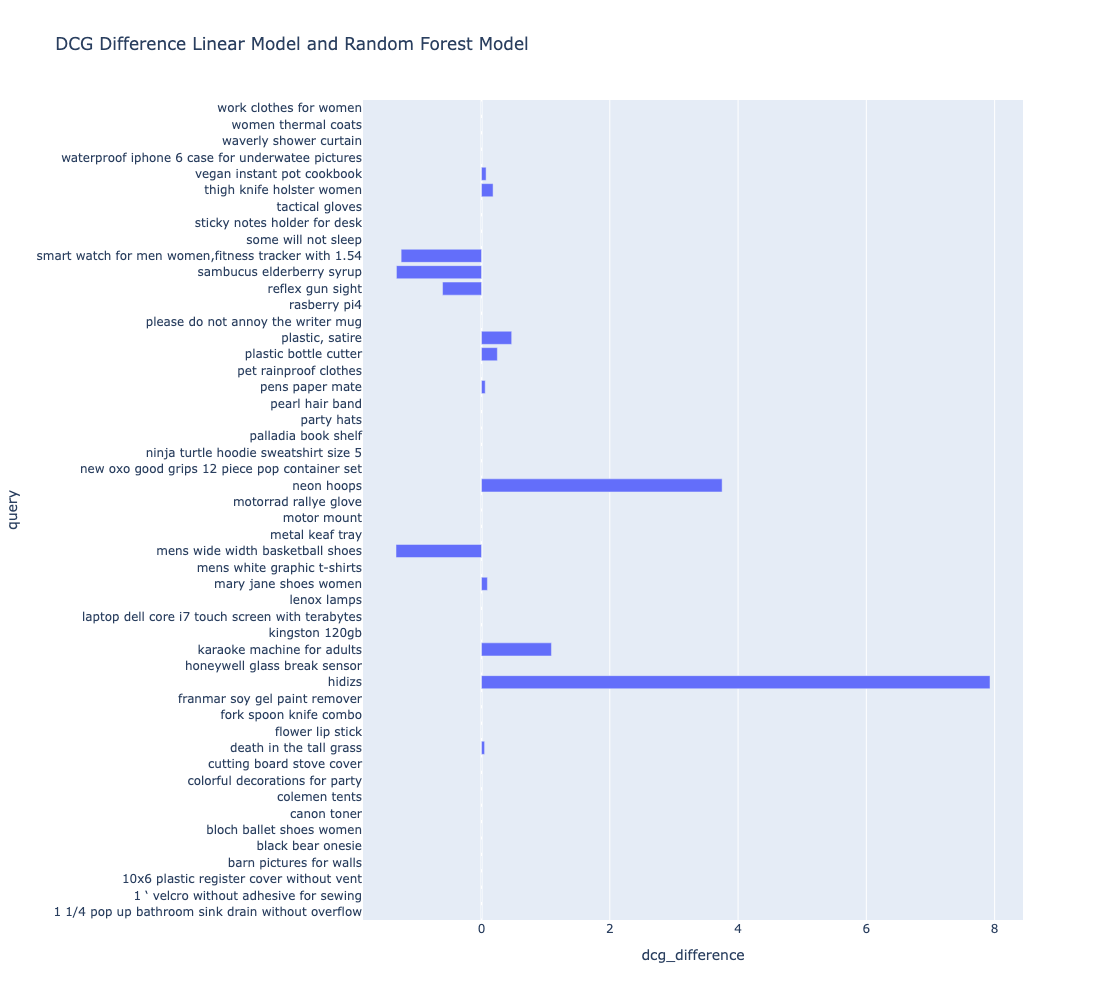

In [330]:
px.bar(df_metrics_merged, x="dcg_difference", y="query", orientation='h',
             hover_data=df_metrics_merged.columns,
             height=1000,
             title='DCG Difference Linear Model and Random Forest Model')